In [277]:
from __future__ import division
import random
random.seed('aco')
import itertools
import networkx as nx
rand_state = random.getstate()

In [278]:
g = nx.Graph()

In [279]:
nodes = frozenset(range(5))

In [280]:
g.add_nodes_from(nodes)

In [281]:
for a, b in itertools.combinations(nodes, 2):
    g.add_edge(a, b, weight=random.randint(1, 9))

In [282]:
nx.set_edge_attributes(g, 'distance', {
    edge: 10 - g.get_edge_data(*edge)['weight']
    for edge in g.edges()
})
positions = nx.spring_layout(g)

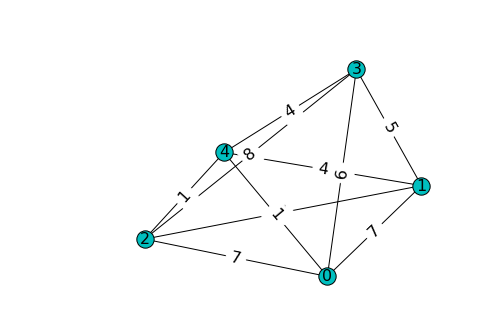

In [283]:
%matplotlib inline
from matplotlib import pyplot as pl
from matplotlib._pylab_helpers import Gcf
from IPython.core.pylabtools import print_figure
from copy import deepcopy

def show_graph(pheromone=None, frames=None):
    if pheromone is None:
        nx.draw(g, positions, node_color='c')
        nx.draw_networkx_labels(g, positions, font_size=16)
        nx.draw_networkx_edge_labels(g, positions, edge_labels={
            edge: g.get_edge_data(*edge)['distance']
            for edge in g.edges()
        }, font_size=16)
    else:
        fig = pl.figure()
        #print fig.axes
        #ax = pl.axes([10, 10, 10, 10])
        #print fig.axes
        #ax = pl.axes()
        ax = pl.gca()
        nx.draw_networkx_nodes(g, positions, node_color='c', ax=ax)
        max_thickness = max(
            pheromone[(a, b)] + pheromone[(b, a)]
            for a, b in g.edges()
        )
        for a, b in g.edges():
            thickness = pheromone[(a, b)] + pheromone[(b, a)]
            nx.draw_networkx_edges(
                g, positions, edgelist=[(a, b)],
                alpha=thickness / max_thickness,
                ax=ax
            )
            
        nx.draw_networkx_labels(g, positions, font_size=16, ax=ax)
        nx.draw_networkx_edge_labels(g, positions, edge_labels={
            edge: g.get_edge_data(*edge)['distance']
            for edge in g.edges()
        }, font_size=16, ax=ax)
        
        fig.add_axes(ax)
    
    if frames is None:
        pl.show()
    else:
        pl.show()
        #last_figure = Gcf.get_all_fig_managers()[-1].canvas.figure
        #last_canvas = Gcf.get_all_fig_managers()[-1].canvas
        #__image_data = "data:image/png;base64,%s" % __b64encode(__print_figure(__last_figure)).decode('utf-8')
        #Gcf.destroy_fig(last_canvas.figure)
        #__PLOTS.append((__iter_key, __image_data))
        frames.append(fig)
        #frames.append(fig.axes + fig.lines)
        #frames.append(fig.axes + [fig.patch] + fig.images + fig.legends + fig.lines + fig.patches + fig.texts)
    
show_graph()

In [284]:
from contextlib import contextmanager
pl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
pl.rcParams['animation.writer'] = 'ffmpeg'
pl.rcParams['animation.html'] = 'html5'
from matplotlib.animation import ArtistAnimation
from matplotlib.image import imread
from tempfile import NamedTemporaryFile
from io import BytesIO, BufferedReader, BufferedWriter, BufferedRWPair
from IPython.display import HTML, display

@contextmanager
def animation():
    frames = []
    yield frames
    images = []
    for frame in frames:
        #temp = NamedTemporaryFile(suffix='.png')
        temp = BytesIO()
        #with open(temp, 'wb') as f:
        #    frame.savefig(f, format='png')
        #with open(temp, 'rb') as f:
        #    images.append(pl.imshow(imread(f)))
        frame.savefig(temp, format='png')
        #images.append(pl.imshow(imread(temp)))
        #print dir(temp)
        images.append(pl.imshow(temp.read()))
    #frames = [
    #    #pl.imshow(imread(frame.savefig(BytesIO(), format='png')))
    #    #imshow(frame.savefig(BytesIO(), format='png'))
    #    frame.savefig(BytesIO(), format='png')
    #    for frame in frames
    #]
    #print dir(frames[0])
    
    fig = pl.figure()
    anim = ArtistAnimation(fig, images, interval=1000, repeat_delay=1000)

    #pl.close(anim._fig)
    display(HTML(anim.to_html5_video()))

In [285]:
pheromone = {
    (a, b): 1 / (len(nodes) - 1)
    for a in nodes
    for b in nodes 
    if a != b
}

distances = {
    (a, b): g.get_edge_data(a, b)['distance']
    for a in nodes
    for b in nodes
    if a != b
}

In [286]:
HEURISTIC_COEFFICIENT = 1
HISTORY_COEFFICIENT = 1

def ant_choice(current, visited, pheromone, distances):
    possible_nodes = {
        node 
        for node in nodes - visited - {current}
        if g.get_edge_data(current, node)
    }
    assert possible_nodes
    
    denom = sum(
        pheromone[(current, node)] ** HISTORY_COEFFICIENT
        * (1 / distances[(current, node)]) ** HEURISTIC_COEFFICIENT
        for node in 
        possible_nodes
    )
    probabilities = {
        node: (
            pheromone[(current, node)] ** HISTORY_COEFFICIENT
            * (1 / distances[(current, node)]) ** HEURISTIC_COEFFICIENT
        ) / denom
        for node in possible_nodes
    }
    
    target = random.random()
    cumsum = 0
    for node, probability in probabilities.iteritems():
        cumsum += probability
        if target <= cumsum:
            return node
    return node

In [287]:
from collections import namedtuple
AntPath = namedtuple('AntPath', 'distance edges')

def simulate_ant(pheromone, distances):
    current = 0
    visited = [current]
    distance = 0
    while set(visited) != nodes:
        next_node = ant_choice(current, set(visited), pheromone, distances)
        distance += distances[(current, next_node)]
        current = next_node
        visited.append(current)
    distance += distances[(current, 0)]  # come back to starting node
    visited.append(0)
    return AntPath(distance, frozenset(zip(visited, visited[1:])))

In [288]:
from collections import defaultdict

DECAY_FACTOR = 1 / 10

def update_pheromone(pheromone, ants):
    edge_ants = defaultdict(list)
    for ant in ants:
        for edge in ant.edges:
            edge_ants[edge].append(ant)
            
    return {
        edge: (1 - DECAY_FACTOR) * previous_pheromone + sum(
            1 / ant.distance for ant in edge_ants[edge]
        )
        for edge, previous_pheromone in 
        pheromone.iteritems()
    }

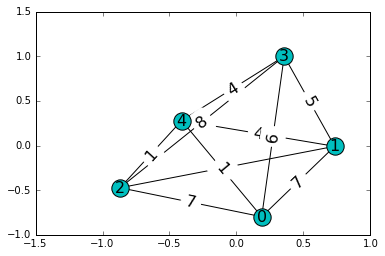

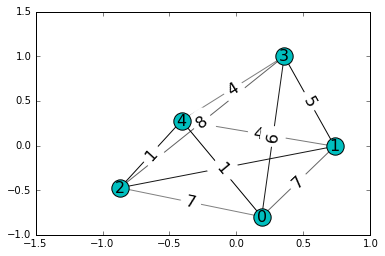

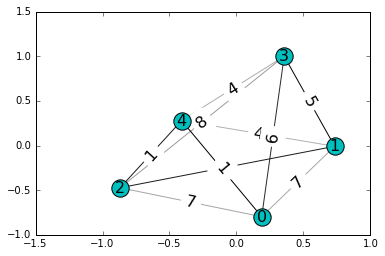

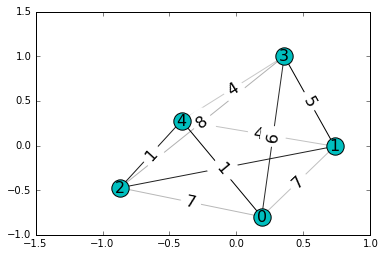

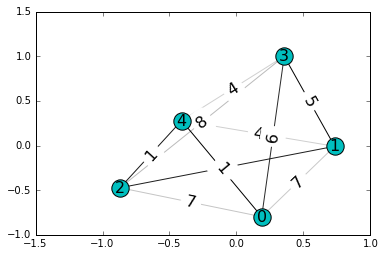

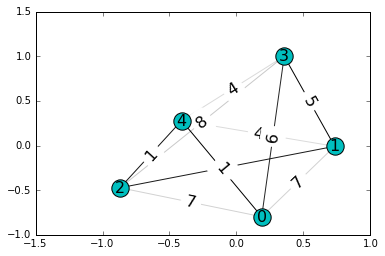

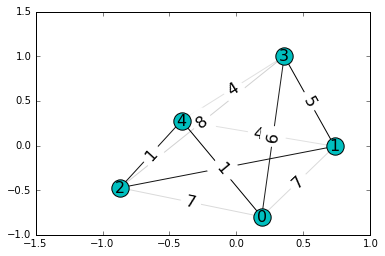

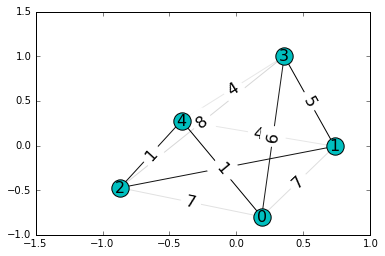

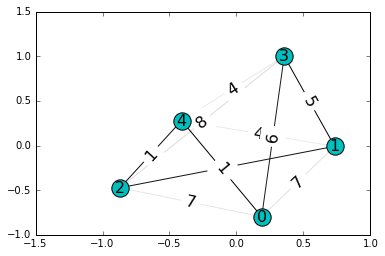

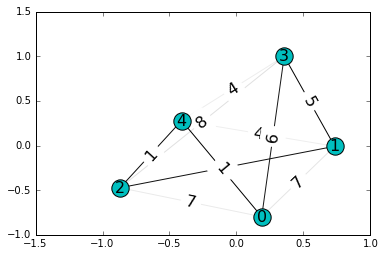

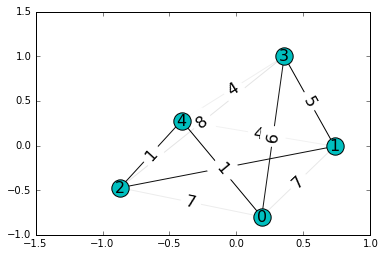

TypeError: Image data can not convert to float

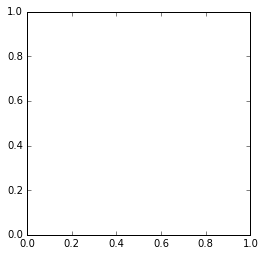

In [289]:
from operator import attrgetter

NUM_ANTS = 25
NUM_ITERATIONS = 10

show_graph(pheromone)

with animation() as frames:
    best_best_ants = []
    for i in xrange(NUM_ITERATIONS):
        ants = []
        while len(ants) < NUM_ANTS:
            try:
                ant = simulate_ant(pheromone, distances)
            except:
                continue
            ants.append(ant)

        best_ant = sorted(ants, key=attrgetter('distance'))
        best_best_ants.append(best_ant)

        pheromone = update_pheromone(pheromone, ants)

        show_graph(pheromone, frames)

In [ ]:
g.remove_edge(2, 4)
del distances[(2, 4)]
del distances[(4, 2)]
show_graph()

In [ ]:
NUM_ITERATIONS = 50

with animation() as frames:
    for i in xrange(NUM_ITERATIONS):
        ants = []
        while len(ants) < NUM_ANTS:
            try:
                ant = simulate_ant(pheromone, distances)
            except:
                continue
            ants.append(ant)

        best_ant = sorted(ants, key=attrgetter('distance'))
        best_best_ants.append(best_ant)

        pheromone = update_pheromone(pheromone, ants)

        show_graph(pheromone, frames)

In [ ]:
import matplotlib.animation as animation
print(animation.writers.list())

In [ ]:
from matplotlib.animation import FFMpegWriter

In [ ]:
FFMpegWriter.isAvailable()